In [3]:
# Import packages
import math
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt

## Financial data forecast

In [9]:
### Import data
start = datetime.strptime('2004-01-02','%Y-%m-%d')
end = datetime.strptime('2022-3-31','%Y-%m-%d')
series_name, code = r'HSI', '^HSI'

df = data.DataReader(code, start=start, end=end, data_source='yahoo')
df_close = df['Close']

Text(0, 0.5, 'HSI Price')

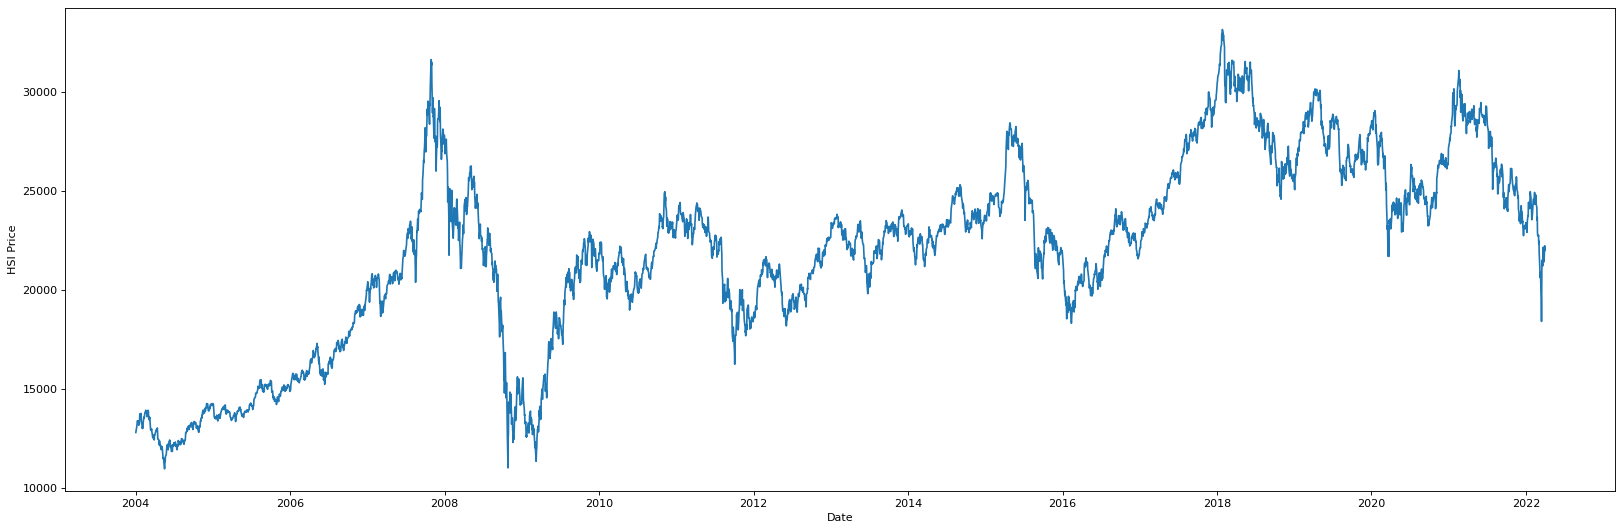

In [10]:
### Plot the series
fig = plt.figure(figsize=(25,8), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(df_close)
ax.set_xlabel('Date')
ax.set_ylabel('{} Price'.format(series_name))

### I. ARIMA

### II. LSTM model

In [12]:
### Map all data into [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [13]:
### Split out training and test datasets
training_size = int(len(data)*0.65)
test_size = len(data)-training_size
train_data, test_data = data[0:training_size,:], data[training_size:len(data),:]

In [14]:
### Build input features with time lag of 1 day
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [15]:
### Reshape the datasets into (#values, #time-steps, #1 dimensional output)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

In [17]:
### Build different LSTM models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

###### Prof's model
model = Sequential() 
model.add(LSTM(50, return_sequences = True, input_shape = (100,1))) 
model.add(LSTM(50, return_sequences = True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
### Train LSTM models
lstm_history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
45/45 [==============================] - 10s 141ms/step - loss: 0.0206 - val_loss: 0.0034
Epoch 2/100
45/45 [==============================] - 5s 113ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/100
45/45 [==============================] - 5s 110ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 4/100
45/45 [==============================] - 5s 118ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
45/45 [==============================] - 5s 119ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/100
45/45 [==============================] - 5s 120ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 7/100
45/45 [==============================] - 5s 116ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/100
45/45 [==============================] - 5s 117ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/100
45/45 [==============================] - 5s 118ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/100
45/45 [==============================] - 5s 121ms/step - loss: 9.6802e-04 - v

In [19]:
### Make predictions and inverse-map (0,1) to the true stock prices
def predictLSTM(model, train_input, test_input):
    train_predict = model.predict(train_input)
    test_predict = model.predict(test_input)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    return train_predict, test_predict

train_predict, test_predict = predictLSTM(model, x_train, x_test)

In [27]:
### Evaluate the LSTM model
print("Loss of training dataset", model.evaluate(x_train, y_train, verbose=0),
      "\nLoss of test dataset", model.evaluate(x_test, y_test, verbose=0))

Loss of training dataset 0.00020238755678292364 
Loss of test dataset 0.00022031586559023708


In [28]:
### Get predictions for the whole dataset
look_back = 100

def predict_plot(look_back, train_predict, test_predict):
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict
    return trainPredictPlot, testPredictPlot

trainPredictPlot, testPredictPlot = predict_plot(look_back, train_predict, test_predict)

<function matplotlib.pyplot.show(close=None, block=None)>

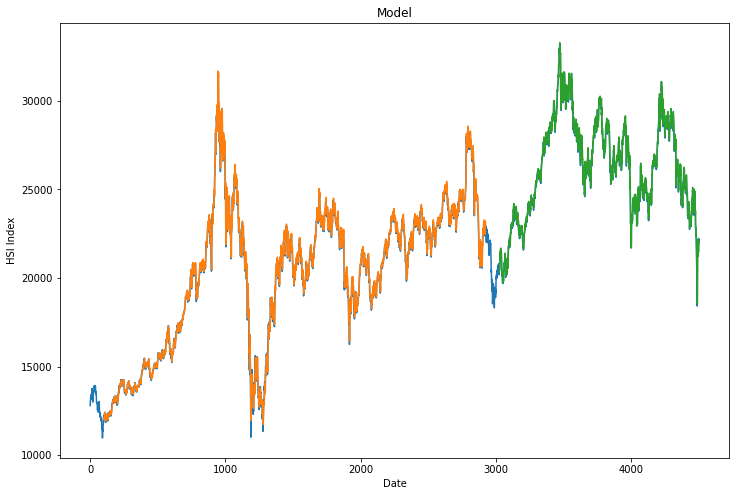

In [29]:
### Plot predictions for the whole dataset
plt.figure(figsize = (12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("Model")
plt.xlabel('Date')
plt.ylabel('HSI Index')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

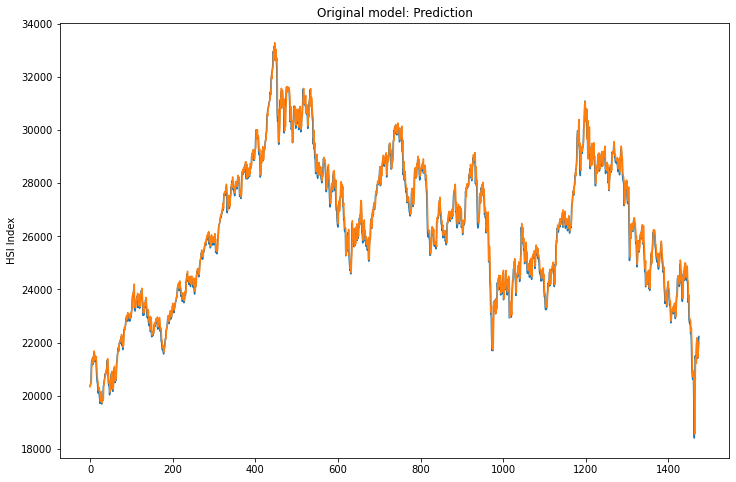

In [30]:
### Plot predictions for test datasets (i.e., zoom in)
plt.figure(figsize = (12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.title("Original model: Prediction")
plt.ylabel('HSI Index')
plt.show

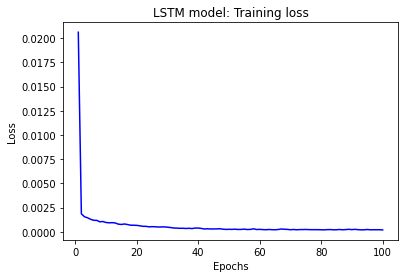

In [31]:
### Plot history for loss
loss_train = lstm_history.history['loss']

epochs = range(1,101)

def chart_loss(loss_value, model_title, loss_func):
    plt.plot(epochs, loss_value, 'b', label='Training loss')
    plt.title(model_title + ': Training loss' + ' (' + loss_func + ')')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

chart_loss(loss_train, "LSTM model")